# Basic functions

In [1]:
%load_ext autoreload
from ExemPy import *
from ExemPy.utils import *
from ExemPy.viz import *
from ExemPy.GCM import *
%aimport ExemPy, ExemPy.utils, ExemPy.viz, ExemPy.GCM
%autoreload 1
import math
import random
import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
from scipy.optimize import minimize
import seaborn as sns
sns.set(style='ticks', context='paper')
colors=["#e3c934","#68c4bf","#c51000","#287271"]
sns.set_palette(colors)

## Set up data
- Read in Peterson and Barney 1952
- Convert Hz to Bark
- Read in confusion matrix from PB52
- Preview pb52

In [2]:
pb52 = pd.read_csv('pb52_data//pb52.csv')
pbcm = pd.read_csv('pb52_data//pbcm.csv').drop([0]).set_index('vowelChoice').rename_axis(None)
hgcm = pd.read_csv('pb52_data//hgcm.csv').drop([0]).set_index('vowelChoice').rename_axis(None)
pb52 = HzToBark(pb52, ["F0", "F1", "F2", "F3"])
pb52.sample(5)

,type,gender,speaker,vowel,repetition,F0,F1,F2,F3,z0,z1,z2,z3
1161,w,f,59,FLEECE,2,261,280,2740,2980,2.620567,2.821250,15.099660,15.642834
1383,c,m,70,KIT,2,212,420,2480,3140,2.086814,4.201176,14.444955,15.976549
1197,w,f,60,GOOSE,2,188,340,920,3050,1.816499,3.433217,8.034306,15.791457
1492,c,m,75,THOUGHT,1,270,535,970,2960,2.716054,5.218838,8.345666,15.599593
981,w,f,50,FLEECE,2,200,400,2600,3100,1.952407,4.014068,14.756404,15.895099


## Set default parameters (based on previous work)
- dimensions *m* & attention weights *w*
- list of categories
- exemplar sensitivity *c*
- set to be categorized 
- exemplar cloud used to categorize against

In [3]:
dimsvals={'z0' : 1,
          'z1' : 2.56,
          'z2' : 1.985,
          'z3' : 1.34}

dimslist = list(dimsvals.keys())

catslist = ['type', 'vowel']           # man, woman, or child; lexical set notation

cval = 25


## Categorize one stimulus
You can also use the function xm.categorize() to do these steps all at once! (Note, however, that you won't be able to visualize and verify at each step of the process!)

### Set up
- Randomly select a stimulus
- Add an resting activation *N* value of 1to all stored exemplars
- Exclude the stimulus from the exemplar cloud
    - This way, the stimulus will not be compared to itself

In [4]:
stim = pb52.sample()
stim

,type,gender,speaker,vowel,repetition,F0,F1,F2,F3,z0,z1,z2,z3
855,w,f,43,FOOT,2,233,467,1167,2595,2.318486,4.628743,9.475523,14.743754


In [5]:
exemplars = reset_N(pb52, N = 1)
exemplars = exclude(exemplars, stim, exclude_self = True)
print(exemplars.sample())

    type gender  speaker  vowel  repetition     F0     F1      F2      F3  \
685    w      f     35.0  DRESS         2.0  210.0  630.0  2300.0  3170.0   

           z0        z1         z2         z3  N  
685  2.064516  5.991351  13.944883  16.036803  1  


In [6]:
o = stim.isin(exemplars)
print('Is stim contained within exemplars?')
print(o)


Is stim contained within exemplars?
      type  gender  speaker  vowel  repetition     F0     F1     F2     F3  \
855  False   False    False  False       False  False  False  False  False   

        z0     z1     z2     z3  
855  False  False  False  False  


### Calculate activation of each exemplar wrt the stimulus
- For exemplars that share categories with stimulus,
    - activation (a) *a* is higher
    - distance (dist) *d* is lower
- Plot activation:
    - exemplars plotted in F2, F1 (Bark) space
    - stimulus plotted in a blue X
    - color = exemplar category
    - size = activation

In [7]:
activation_df = activation(
    testset = stim,
    cloud = reset_N(exemplars, N=1),
    dimsdict = dimsvals,
    c = cval
    )

In [8]:
print("---- Stimulus info ----")
print(stim[['type', 'vowel', 'speaker']])
print("")
print(stim[['F0', 'F1', 'F2', 'F3']])
print("-----------------------")
smallactivdf = activation_df[['a',
                      'dist',
                      'type_ex',
                      'vowel_ex',
                      'F0_ex',
                      "F1_ex",
                      "F2_ex",
                      "F3_ex"]]
print(gettestset(smallactivdf, "vowel_ex", n = 2))

---- Stimulus info ----
    type vowel  speaker
855    w  FOOT       43

      F0   F1    F2    F3
855  233  467  1167  2595
-----------------------
                 a      dist type_ex vowel_ex  F0_ex   F1_ex   F2_ex   F3_ex
160   5.916923e-25  2.231472       m   FLEECE  175.0   316.0  2200.0  2800.0
700   7.340776e-33  2.959675       w   FLEECE  210.0   290.0  2700.0  3020.0
1261  4.186318e-34  3.074243       c      KIT  290.0   580.0  2760.0  3400.0
483   2.311896e-19  1.716442       m      KIT  108.0   430.0  1940.0  2590.0
924   6.340351e-27  2.412915       w    DRESS  260.0   520.0  2340.0  3040.0
1203  1.499031e-21  1.917979       w    DRESS  245.0   640.0  1980.0  2920.0
1006  2.697548e-29  2.631305       w     TRAP  203.0   678.0  2420.0  3080.0
267   2.640673e-18  1.619020       m     TRAP  109.0   750.0  1710.0  2440.0
1008  2.242467e-12  1.072938       w    STRUT  214.0   772.0  1280.0  2660.0
449   9.100084e-10  0.832703       m    STRUT  124.0   650.0  1000.0  2520.0
50  

In [9]:
act = getactiv(activation_df, 'z2', 'z1', 'vowel')

<AxesSubplot:xlabel='z2', ylabel='z1'>

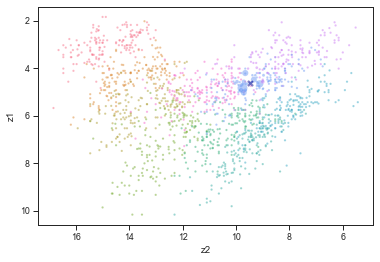

In [10]:
activplot(act, 'z2', 'z1', 'vowel', stim)

### Calculate probabilities & choose
Use Luce's choice rule to calculate probabilities & choose
- Calculate probability for categorization as each label
    - Add up activation by category
    - Add up total amount of activation
    - Divide category activation by total activation
        - Probability of being categorized as that
- Choose the label with the highest probability
        
        
        

In [11]:
pr = probs(activation_df, catslist)
pr

{'type':   type  probability
 0    c     0.041233
 1    m     0.110480
 2    w     0.848287,
 'vowel':      vowel   probability
 0    DRESS  1.011615e-12
 1   FLEECE  2.450425e-21
 2     FOOT  9.522804e-01
 3    GOOSE  4.659325e-02
 4      KIT  7.843954e-14
 5    NURSE  1.351160e-11
 6     PALM  1.100953e-04
 7    STRUT  8.571126e-04
 8  THOUGHT  1.591088e-04
 9     TRAP  1.147804e-10}

In [12]:
choices = choose(pr, stim, catslist)
choices[['typeChoice','typeProb','vowelChoice','vowelProb']]

,typeChoice,typeProb,vowelChoice,vowelProb
855,w,0.848287,FOOT,0.95228


### Check for "veridical perception"

In [13]:
accu = checkaccuracy(choices, catslist)
print('Was vowel categorized accurately?          '
      + accu.iloc[0]['vowelAcc'])
print('Was speaker type categorized accurately?   '
      + accu.iloc[0]['typeAcc'])

Was vowel categorized accurately?          y
Was speaker type categorized accurately?   y


## Categorize dataset with respect to itself
In the past sections we:
- Set some parameters for categorization, including
    - Dimensions & their attention weights
    - Category types to categorize for
- Calculate the activation of each exemplar wrt the stimulus
- Calculate probabilities
- Choose the most probable category label for each category type
- Evaluate the stimulus

Now, let's do the same process with <b> multiple </b> exemplars. In fact, let's simulate the perception component of Peterson and Barney 1952 by having our "perceiver" categorize every exemplar.

### First, let's re-set our variables
As a reminder or in case something got wonky!

In [14]:
dimsvals={'z0' : 1,
          'z1' : 2.56,
          'z2' : 1.985,
          'z3' : 1.34}

dimslist = list(dimsvals.keys())

catslist = ['type', 'vowel']

cval = 25

exemplars = pb52
test = pb52

### Next, let's categorize!
This may take a minute!

In [15]:
choices = multicat(
    testset = test,
    cloud = exemplars,
    cats = catslist,
    dimsdict = dimsvals,
    c = cval,
    N = 1,
    exclude_self = True)

In [16]:
print(choices)

     type gender  speaker   vowel  repetition   F0   F1    F2    F3        z0  \
0       m      m        1  FLEECE           1  160  240  2280  2850  1.493396   
1       m      m        1  FLEECE           2  186  280  2400  2790  1.793700   
2       m      m        1     KIT           1  203  390  2030  2640  1.986149   
3       m      m        1     KIT           2  192  310  1980  2550  1.861970   
4       m      m        1   DRESS           1  161  490  1870  2420  1.505083   
...   ...    ...      ...     ...         ...  ...  ...   ...   ...       ...   
1515    c      f       76    FOOT           2  322  610  1550  3400  3.253006   
1516    c      f       76   GOOSE           1  345  520  1250  3460  3.482777   
1517    c      f       76   GOOSE           2  334  500  1140  3380  3.373461   
1518    c      f       76   NURSE           1  308  740  1850  2160  3.110864   
1519    c      f       76   NURSE           2  328  660  1830  2200  3.313392   

            z1         z2  

### Check accuracy
- We'll get a dataframe where each exemplar is labeled with whether or not it was categorized accurately (\[CATNAME\]Acc)

Then, for each category type:
- We'll tabulate and plot accuracy by category label
- And then look at overall accuracy as a proportion

In [17]:
acc = checkaccuracy(choices,catslist)
acc.sample(5)

,type,gender,speaker,vowel,repetition,F0,F1,F2,F3,z0,z1,z2,z3,typeChoice,typeProb,vowelChoice,vowelProb,typeAcc,vowelAcc
981,w,f,50,FLEECE,2,200,400,2600,3100,1.952407,4.014068,14.756404,15.895099,w,0.979271,KIT,0.918418,y,n
345,m,m,18,DRESS,2,129,490,1930,2650,1.125572,4.832000,12.771620,14.881388,m,0.999460,KIT,0.645001,y,n
1198,w,f,60,NURSE,1,222,530,1670,2050,2.197690,5.176546,11.804077,13.175860,w,0.628066,NURSE,0.998484,y,y
1247,c,f,63,TRAP,2,285,1140,2000,3560,2.873497,9.329161,13.010404,16.760507,c,0.976449,TRAP,0.871133,y,y
1189,w,f,60,STRUT,2,214,770,1530,2780,2.109071,7.031795,11.223381,15.194008,w,0.981236,STRUT,0.999847,y,y


#### For vowel

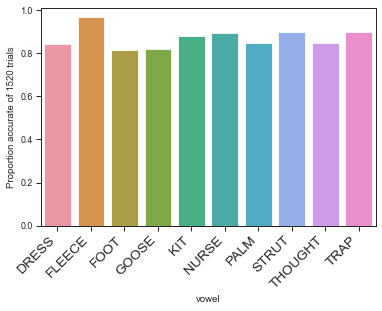

<AxesSubplot:xlabel='vowel', ylabel='Proportion accurate of 1520 trials'>

In [18]:
accplot(acc, 'vowel')

In [19]:
propcorr(acc,'vowel')

,vowel,propcorr
0,DRESS,0.842105
1,FLEECE,0.967105
2,FOOT,0.815789
3,GOOSE,0.822368
4,KIT,0.881579
5,NURSE,0.894737
6,PALM,0.848684
7,STRUT,0.901316
8,THOUGHT,0.848684
9,TRAP,0.901316


In [20]:
print("Overall accuracy: " + str(overallacc(acc,'vowel')))

Overall accuracy: 0.8723684210526316


#### For speaker type (man, woman, child)

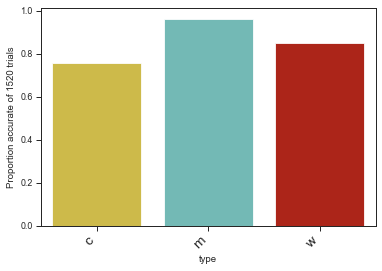

<AxesSubplot:xlabel='type', ylabel='Proportion accurate of 1520 trials'>

In [21]:
accplot(acc,'type')

In [22]:
propcorr(acc,'type')

,type,propcorr
0,c,0.756667
1,m,0.962121
2,w,0.851786


In [23]:
print("Overall accuracy: " + str(overallacc(acc,'type')))

Overall accuracy: 0.8809210526315789


### Get confusion matrices
- Calculate a confusion matrix for our "perceiver"
- Look at the confusion matrix from the Peterson and Barney paper we read in earlier

In [24]:
cm = confusion(choices,catslist)['vowel']
cm

vowelChoice,DRESS,FLEECE,FOOT,GOOSE,KIT,NURSE,PALM,STRUT,THOUGHT,TRAP
DRESS,0.84,0.00,0.00,0.00,0.12,0.01,0.00,0.00,0.00,0.03
FLEECE,0.00,0.97,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00
FOOT,0.00,0.00,0.82,0.13,0.00,0.00,0.00,0.03,0.02,0.00
GOOSE,0.00,0.00,0.14,0.82,0.00,0.00,0.00,0.00,0.04,0.00
KIT,0.07,0.05,0.00,0.00,0.88,0.00,0.00,0.00,0.00,0.00
NURSE,0.06,0.00,0.00,0.00,0.02,0.89,0.00,0.00,0.00,0.03
PALM,0.00,0.00,0.00,0.00,0.00,0.00,0.85,0.09,0.06,0.00
STRUT,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.90,0.01,0.00
THOUGHT,0.00,0.00,0.01,0.03,0.00,0.00,0.09,0.02,0.85,0.00
TRAP,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.90


In [25]:
pbcm

,DRESS,FLEECE,FOOT,GOOSE,KIT,NURSE,PALM,STRUT,THOUGHT,TRAP
DRESS,0.658,0.013,0.004,0.001,0.237,0.011,0.000,0.003,0.000,0.072
FLEECE,0.006,0.962,0.000,0.000,0.031,0.000,0.000,0.000,0.000,0.000
FOOT,0.001,0.000,0.620,0.284,0.002,0.009,0.001,0.052,0.031,0.000
GOOSE,0.000,0.002,0.090,0.891,0.002,0.002,0.000,0.007,0.007,0.000
KIT,0.067,0.251,0.006,0.000,0.670,0.001,0.000,0.001,0.000,0.003
NURSE,0.040,0.003,0.030,0.007,0.041,0.866,0.000,0.009,0.000,0.003
PALM,0.002,0.000,0.006,0.001,0.000,0.000,0.550,0.136,0.305,0.001
STRUT,0.009,0.000,0.027,0.001,0.001,0.012,0.128,0.747,0.068,0.007
THOUGHT,0.000,0.000,0.130,0.059,0.000,0.000,0.059,0.080,0.672,0.000
TRAP,0.280,0.001,0.003,0.000,0.006,0.019,0.040,0.020,0.000,0.632


### Next, let's analyze the confusion matrices in a couple different ways
- Take a simple difference
- Set up a dataframe to look at correlations
    - Convert matrices to stacksw
    - Join together into dataframe
- Calculate root mean square
- Get correlation using df.corr
- Set up a dataframe where all 0s are converted to NaN
    - Afterall, 0 correlates real good with 0!
- Get RMS
- Get correlation

In [26]:
cm - pbcm #differences

vowelChoice,DRESS,FLEECE,FOOT,GOOSE,KIT,NURSE,PALM,STRUT,THOUGHT,TRAP
DRESS,0.182,-0.013,-0.004,-0.001,-0.117,-0.001,0.000,-0.003,0.000,-0.042
FLEECE,-0.006,0.008,0.000,0.000,-0.001,0.000,0.000,0.000,0.000,0.000
FOOT,-0.001,0.000,0.200,-0.154,-0.002,-0.009,-0.001,-0.022,-0.011,0.000
GOOSE,0.000,-0.002,0.050,-0.071,-0.002,-0.002,0.000,-0.007,0.033,0.000
KIT,0.003,-0.201,-0.006,0.000,0.210,-0.001,0.000,-0.001,0.000,-0.003
NURSE,0.020,-0.003,-0.030,-0.007,-0.021,0.024,0.000,-0.009,0.000,0.027
PALM,-0.002,0.000,-0.006,-0.001,0.000,0.000,0.300,-0.046,-0.245,-0.001
STRUT,-0.009,0.000,-0.027,-0.001,-0.001,-0.012,-0.038,0.153,-0.058,-0.007
THOUGHT,0.000,0.000,-0.120,-0.029,0.000,0.000,0.031,-0.060,0.178,0.000
TRAP,-0.180,-0.001,-0.003,0.000,-0.006,-0.019,-0.040,-0.020,0.000,0.268


In [27]:
# flatten and combine confusion matrices
pbcmfl = pd.Series(pbcm.stack(), name = "PB")
cmfl = pd.Series(cm.stack(), name = "GCM")
cms = pd.concat([pbcmfl, cmfl], axis = 1)

#Remove 0s (which correlate with each other)
cmsnan = cms.replace(0, np.nan) 

In [28]:
print("0s included")
print("RMS =  ", (((cms.PB-cms.GCM) ** 2).mean()) ** .5)
print("r =    ", (cms['PB'].corr(cms['GCM'])))
print("")
print("0s removed")
print("RMS =  ",(((cmsnan.PB-cmsnan.GCM) ** 2).mean()) ** .5)
print("r =    ", cmsnan['PB'].corr(cmsnan['GCM']))

0s included
RMS =   0.0741105255682349
r =     0.964581333955327

0s removed
RMS =   0.12843085629429107
r =     0.9519894540508784
